In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import matplotlib.pyplot as plt
from avgn.utils.audio import load_wav
from avgn.signalprocessing.filtering import butter_bandpass_filter

In [65]:
figsize = (30,5)

In [66]:
import librosa

In [82]:
wav_dict = {
    'starling': '/mnt/cube/Datasets/starling_zenodo/b1160/wavs/2017-11-17_17-11-06-610000.wav',
    'mouse': '/mnt/cube/Datasets/mouse_usv/VOC592/VOC592_VOC571_SONG_CMPA_9_20_2016_56_24.52.WAV',
    #'canary': '/mnt/cube/Datasets/canary/FromYarden2018/bird_3/bird3_0244_2004_03_14_14_15.wav',
    'canary': '/mnt/cube/Datasets/canary/FromYarden2018/bird_1/bird1_0001_2004_03_05_18_14.wav',
    'bengalese_finch': '/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/bengalese_finch_sober/2019-09-02_17-08-52/WAV/or60yw70_300912_2036.4169.WAV'
}

In [83]:
wav_loc = wav_dict['canary']
#'/mnt/cube/Datasets/starling_zenodo/b1160/wavs/2017-11-17_17-11-06-610000.wav'

In [84]:
rate, data = load_wav(wav_loc)
#data = data[rate*20:rate*30]

In [85]:
rate/2-1

23999.0

In [86]:
data = butter_bandpass_filter(data, 500.0, rate/2-1, rate, order=2)

In [87]:
len(data)/rate

17.694041666666667

In [88]:
#data = data[rate*5:rate*10]

In [89]:
len(data)/rate

17.694041666666667

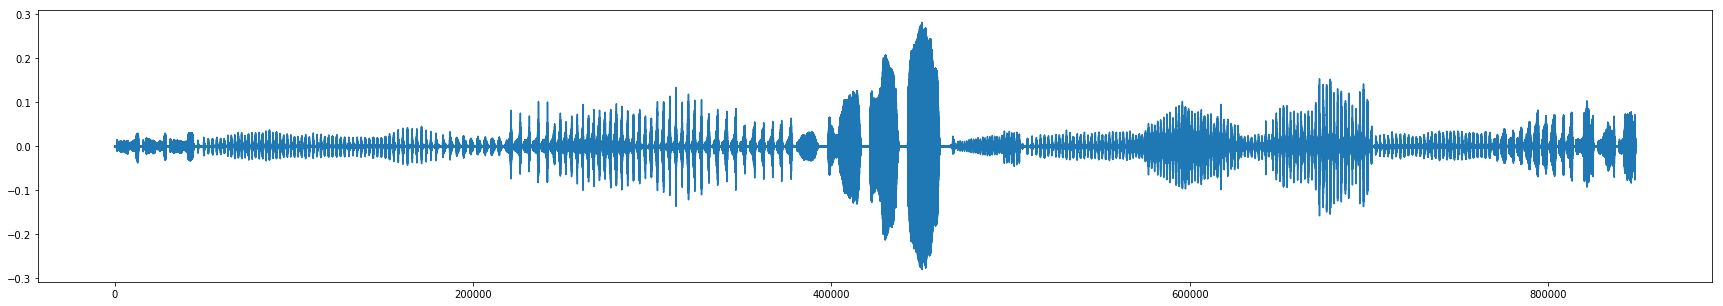

In [90]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(data)

In [91]:
from avgn.visualization.spectrogram import plot_spec
import numpy as np
from tqdm.autonotebook import tqdm
from scipy import signal, ndimage
import matplotlib
import librosa

cmap = matplotlib.colors.ListedColormap(np.random.rand(256, 3))
cmap.set_bad(color=(0, 0, 0, 0))


def norm(x, _type="zero_one"):
    return (x - np.min(x)) / (np.max(x) - np.min(x))


class HParams(object):
    """ Hparams was removed from tf 2.0alpha so this is a placeholder
    """

    def __init__(self, **kwargs):
        self.set_defaults()
        self.__dict__.update(kwargs)

    def set_defaults(self):
        self.win_length_ms = 5
        self.hop_length_ms = 1
        self.n_fft = 1024
        self.ref_level_db = 20
        self.min_level_db = -60
        self.preemphasis = 0.97

    def save(self):
        raise NotImplementedError

    def load(self):
        raise NotImplementedError


def _normalize(S, hparams):
    return np.clip((S - hparams.min_level_db) / -hparams.min_level_db, 0, 1)


def spectrogram(y, fs, hparams):
    return _normalize(spectrogram_nn(y, fs, hparams), hparams)


def spectrogram_nn(y, fs, hparams):
    D = _stft(preemphasis(y, hparams), fs, hparams)
    S = _amp_to_db(np.abs(D)) - hparams.ref_level_db
    return S


def preemphasis(x, hparams):
    return signal.lfilter([1, -hparams.preemphasis], [1], x)


def _stft(y, fs, hparams):
    return librosa.stft(
        y=y,
        n_fft=hparams.n_fft,
        hop_length=int(hparams.hop_length_ms / 1000 * fs),
        win_length=int(hparams.win_length_ms / 1000 * fs),
    )


def _amp_to_db(x):
    return 20 * np.log10(np.maximum(1e-5, x))


def segment_mask(mask):
    """ segments a binary spectrogram mask into individual elements
    """
    elements, _ = ndimage.label(mask == False)
    elements = np.ma.masked_where(elements == 0, elements)
    elements = np.array(elements.data).astype("float32")
    return elements


def mask_spectrogram(spec, mask_thresh_std):
    return (
        (spec.T < (np.median(spec, axis=1) + mask_thresh_std * np.std(spec, axis=1)) + 1e-5)
        .astype("float32")
        .T
    )


def gen_continuity_filter(
    neighborhood_freq_hz, neighborhood_time_ms, spec_bin_hz, hop_length_ms
):
    """ Generate a filter for continuous elements
    """
    n_bin_freq = int(neighborhood_freq_hz / spec_bin_hz)
    n_bin_time = int(neighborhood_time_ms / hop_length_ms)
    return np.ones((n_bin_freq, n_bin_time)) / np.product((n_bin_freq, n_bin_time))


def threshold_continuity(spec, continuity_filter):
    return


def merge_overlapping_elements(elements, cluster_overlap_thresh):
    """ merge overlapping elements in spectrogram into syllables
    """
    # get unique points
    unique_elements = np.unique(elements[elements != 0].astype(int))

    # get the time coverage of each element
    total_coverage = [np.sum(elements == i, axis=0) for i in unique_elements]

    # sort by the length of the element
    size_sort = np.argsort(np.sum(np.array(total_coverage) > 0, axis=1))

    # rearrage based upon size
    unique_elements = unique_elements[size_sort]
    total_coverage = np.array(total_coverage)[size_sort]

    # loop through each element in order of size and add it to larger clusters
    #   if it overlaps by at least overlap_thresh, merge the two elements
    for tci, (dp, tc) in tqdm(
        enumerate(zip(unique_elements, total_coverage)), total=len(unique_elements)
    ):
        # find where this syllable is
        tc_spot = np.where(tc > 0)[0]
        # find elements overlapping this element
        matching_cluster = np.where(
            (np.sum(total_coverage[tci + 1 :, tc_spot] > 0, axis=1))
            > (len(tc_spot) * cluster_overlap_thresh)
        )[0]

        # if there are any, add this element to that group
        if len(matching_cluster) > 0:
            matching_cluster_id = unique_elements[matching_cluster[-1] + tci + 1]
            total_coverage[matching_cluster[-1] + tci + 1] += tc
            elements[elements == dp] = matching_cluster_id

    # rename clusters
    #unique_elements = np.unique(elements[elements != 0].astype(int))
    #remap_dict = {
    #    dp: ndp
    #    for dp, ndp in zip(unique_elements, np.random.permutation(unique_elements))
    #}
    #for k, v in remap_dict.items():
    #    elements[elements == k] = v
    return elements


def get_syllable_timing(elements, hop_length_ms):
    
    unique_elements = np.unique(elements[elements != 0].astype(int))
    
    # get unique points
    unique_elements = np.unique(elements[elements != 0].astype(int))

    # get the time coverage of each element
    total_coverage = [np.sum(elements == i, axis=0) for i in unique_elements]
    
    # get the start and end times of each syllable
    syllable_start_times, syllable_end_times = (
        np.array(
            [
                np.where(i > 0)[0][np.array([0, -1])]
                for i in tqdm(total_coverage, desc="element length")
            ]
        ).T
        * hop_length_ms
    )
    return syllable_start_times, syllable_end_times

def syllabify(
    waveform,
    fs,
    verbose=False,
    mask_thresh_std=0.5,
    neighborhood_time_ms=5,
    neighborhood_freq_hz=500,
    neighborhood_thresh=0.5,
    cluster_overlap_thresh=0.8,
    n_fft=512,
    ref_level_db=20,
    min_level_db=-100,
    win_length_ms=10,
    hop_length_ms=3,
    spectral_range = None,
    max_element_len_ms = 500,
    figsize=(30, 5),
):
    """
    
    Args:
       mask_thresh_std (float): how many standard deviations above the median to
            threshold the spectrogram 
       neighborhood_time_ms (float):
       neighborhood_freq_hz (float): 
       neighborhood_thresh (float): the nubmer of continuous bins in the defined 
           neighborhoods that need to be active for the bin to be abvoe the threshold
       cluster_overlap_thresh (float): threshold for cluster element size
       max_element_len_ms (float): longest acceptable syllable length in ms
    """
    with tqdm(total=5) as pbar:
        ### create a spectrogram
        pbar.set_description("Generating spectrogram")
        hparams = HParams(
            n_fft=n_fft,
            ref_level_db=ref_level_db,
            min_level_db=min_level_db,
            win_length_ms=win_length_ms,
            hop_length_ms=hop_length_ms,
        )
        spec = spectrogram(waveform, fs, hparams)
        spec_bin_hz = (rate / 2) / np.shape(spec)[0]

        if spectral_range is not None:
            spec = spec[int(spectral_range[0] / spec_bin_hz):int(spectral_range[1] / spec_bin_hz),:]

        if verbose:
            fig, ax = plt.subplots(figsize=figsize)
            plot_spec(spec, fig=fig, ax=ax, cmap=plt.cm.Greys)        
        
        ### create a mask
        pbar.set_description("Thresholding spectrogram")
        pbar.update(1)
        mask = mask_spectrogram(spec, mask_thresh_std)

        if verbose:
            fig, ax = plt.subplots(figsize=figsize)
            plot_spec(mask, fig=fig, ax=ax, cmap=plt.cm.Greys_r)
            plt.show()

         # Create a smoothing filter for the mask in time and frequency
            
        continuity_filter = gen_continuity_filter(
            neighborhood_freq_hz, neighborhood_time_ms, spec_bin_hz, hop_length_ms
        )
        print(np.shape(continuity_filter))
        
        #### iteratively decrease noise threshold until syllables are a reasonable length
        for i in range(10):
            
            ### remove non-continuous regions of the mask
            pbar.set_description("Removing non-continuous noise")
            pbar.update(2)

           

            # apply filter
            mask_mask = signal.fftconvolve(
                (1 - mask.astype("float32")), continuity_filter, mode="same"
            )
            # threshold filter
            mask_mask = mask_mask < neighborhood_thresh

            if verbose:
                fig, ax = plt.subplots(figsize=figsize)
                plot_spec(mask_mask.astype("float"), fig=fig, ax=ax, cmap=plt.cm.Greys_r)
                plt.show()

            # cluster elements in masked spectrogram
            pbar.set_description("Clustering elements in spectrogram")
            pbar.update(3)

            # find continous elements
            elements = segment_mask(mask_mask)

            if verbose:
                unique_elements = np.unique(elements[elements != 0].astype(int))
                print("Unique elements: {}".format(len(unique_elements)))
                fig, ax = plt.subplots(figsize=figsize)
                elements_copy = elements.copy()
                elements_copy[elements_copy == 0] = np.nan
                plot_spec(elements_copy, fig=fig, ax=ax, cmap=cmap)
                plt.show()

            # merge elements
            pbar.set_description("merging elements into syllables")
            pbar.update(4)
            
            # get the start and end times of each syllable
            syllable_start_times, syllable_end_times = get_syllable_timing(elements, hop_length_ms)
            
            longest_syllable = np.max(syllable_end_times - syllable_start_times)
            print(longest_syllable)
            if longest_syllable <= max_element_len_ms:
                break
            neighborhood_thresh += 0.1

        # loop through each element in order of size and add it to larger clusters
        #   if it overlaps by at least overlap_thresh, merge the two elements
        elements = merge_overlapping_elements(elements, cluster_overlap_thresh)

        if verbose:
            unique_elements = np.unique(elements[elements != 0].astype(int))
            print("Unique elements: {}".format(len(unique_elements)))
            fig, ax = plt.subplots(figsize=figsize)
            elements_copy = elements.copy()
            elements_copy[elements_copy == 0] = np.nan
            plot_spec(elements_copy, fig=fig, ax=ax, cmap=cmap)
            plt.show()
            
        ### merge smaller elements

        
        ### get element boundaries
        
        #if verbose:
        #    fig, ax = plt.subplots(figsize=figsize)
        #    spec_masked = spec.copy()
        #    spec_masked[mask_mask != 0] = 0
        #    plot_spec(spec_masked, fig=fig, ax=ax, cmap=plt.cm.Greys)     
        
        
        
        return elements
        

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


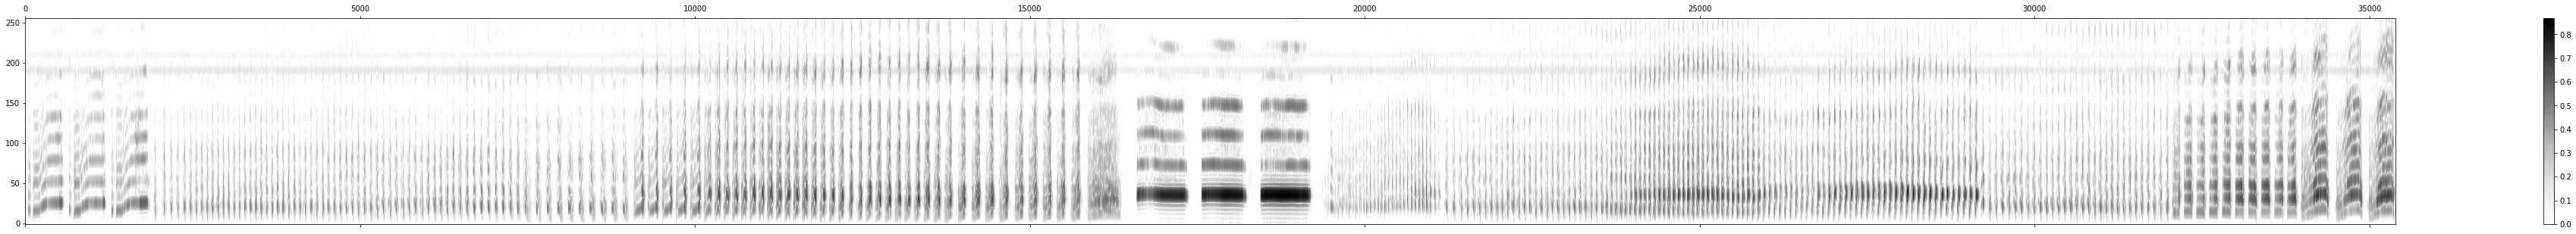

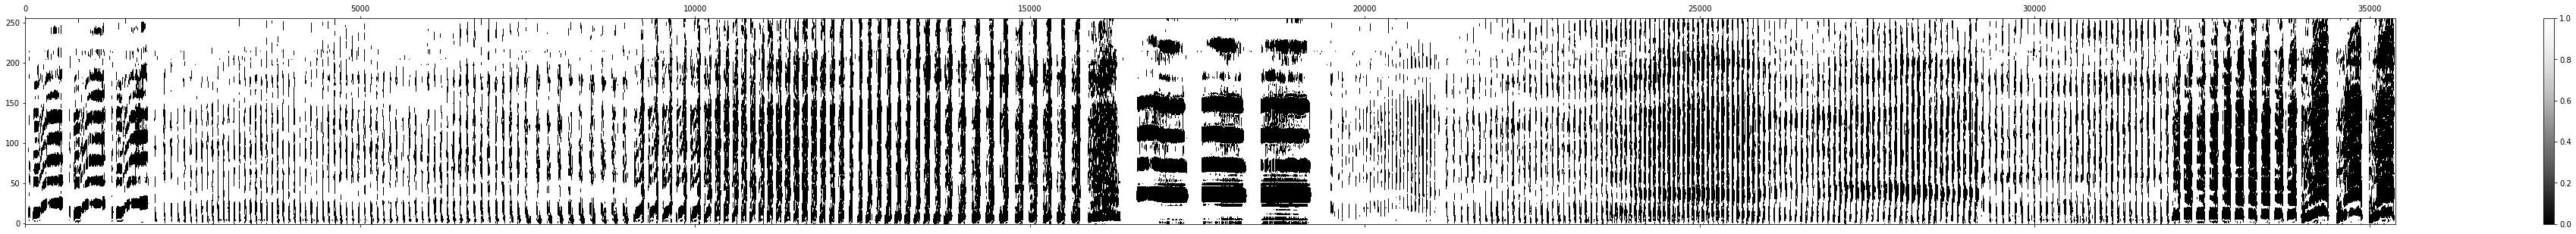

(21, 10)


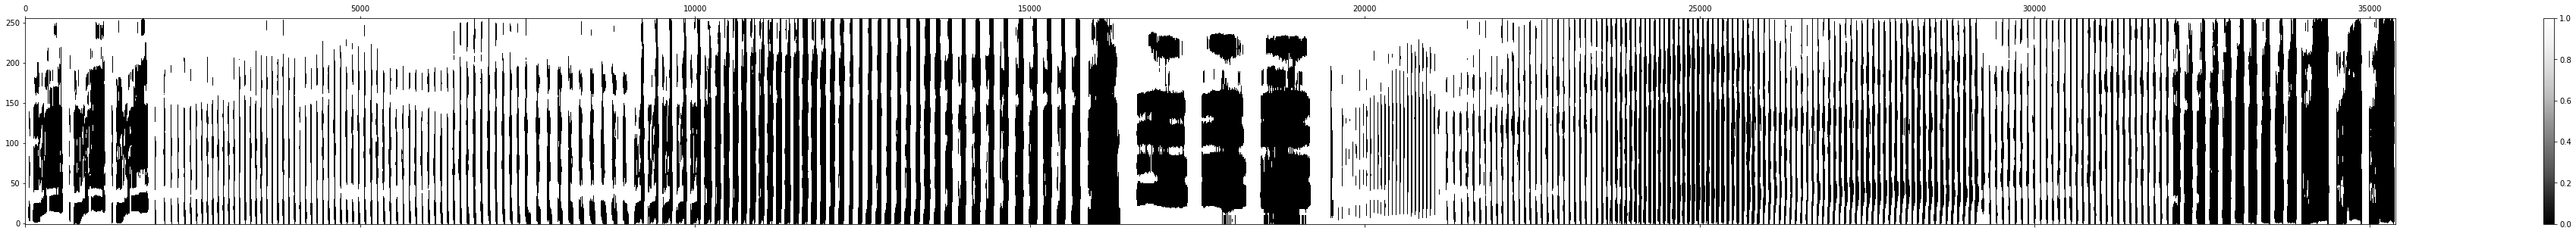

Unique elements: 714


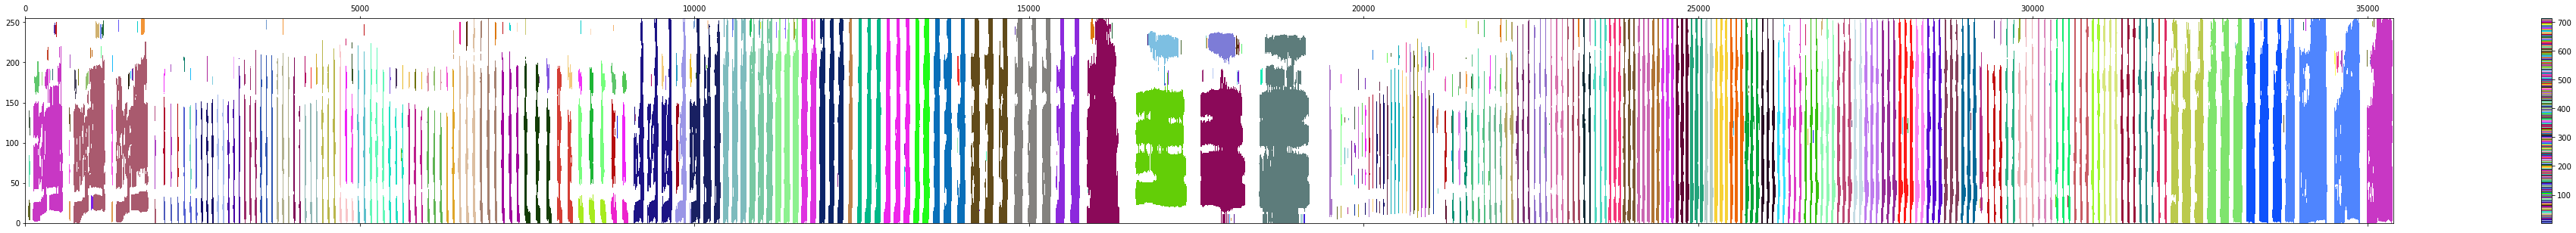

381.0


Unique elements: 328


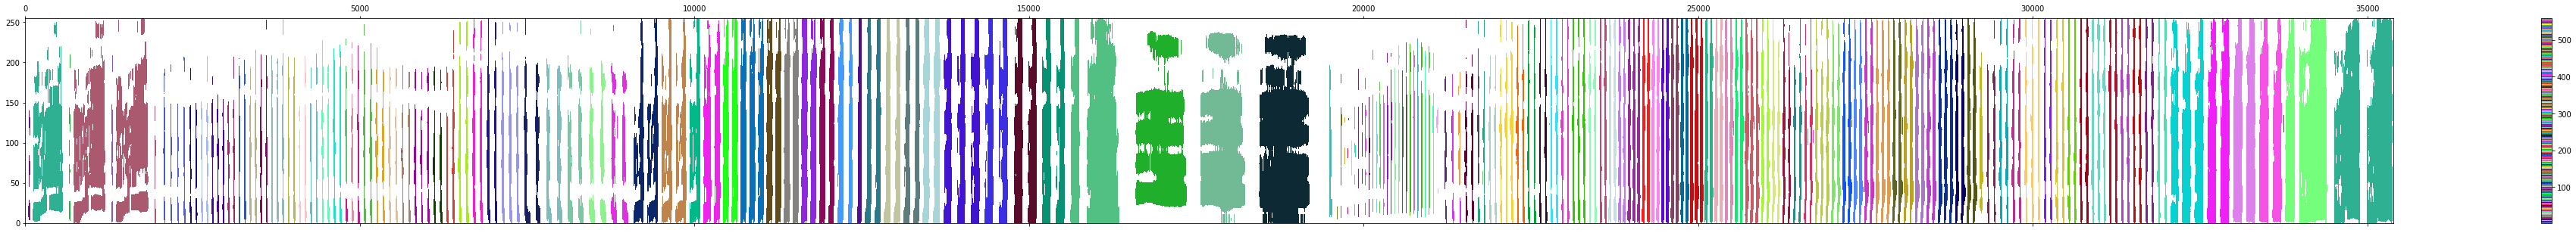

In [92]:
elements = syllabify(
    data,
    rate,
    mask_thresh_std=0.5,
    neighborhood_thresh=0.3,
    neighborhood_time_ms=5,
    neighborhood_freq_hz=2000,
    verbose=True,
    win_length_ms=2,
    hop_length_ms=0.5,
    n_fft=512,
    ref_level_db=20,
    min_level_db=-80,
    spectral_range = [100, 24000],
    figsize=(70, 5),
    max_element_len_ms=2000
)